In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import plotting

import data_higgs as dh

# i know weird file names
from src.network import Network

from tqdm import tqdm

import time


net = Network()


In [24]:
#-------- routines

def split_xy(rawdata):
    #split features and labels from data 
    #prepare the data => normalizations !   

    # split 
    data_y=rawdata['hlabel'] # labels only: 0.=bkg, 1.=sig
    data_x=rawdata.drop(['hlabel'], axis=1) # features only
    
    #now prepare the data
    mu = data_x.mean()
    s = data_x.std()
    dmax = data_x.max()
    dmin = data_x.min()

    # normal/standard rescaling 
    #data_x = (data_x - mu)/s

    # scaling to [-1,1] range
    #data_x = -1. + 2.*(data_x - dmin)/(dmax-dmin)

    # scaling to [0,1] range
    data_x = (data_x - dmin)/(dmax-dmin)


    return data_x,data_y

In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Kaj so podatki?

Vhodni podatki (labels) so čisto navadni vektorji posameznih lastnosti, output pa je zgolj skalar oziroma boolean, če so input vektorji higsov bozon ali ne. Ker so input podatki precej raztroseni, je hiter in zelo učinkovit način procesiranja le teh, da jih pretvorimo v distribucijo - oziroma povemo koliko je posamezna dimenzija vhoda daleč od povprečja.

In [26]:
hdata = dh.load_data()
data_fnames = hdata['feature_names'].to_numpy()[1:]  # labels not needed
n_dims = data_fnames.shape[0]
print("Entries read {} with feature names {}".format(n_dims, data_fnames))

# training sample, should split a fraction for testing
x_trn, y_trn = split_xy(hdata['train'])
x_train, x_test, y_train, y_test = train_test_split(
    x_trn, y_trn, test_size=0.1)  # 10% split
x_val, y_val = split_xy(hdata['valid'])  # independent cross-valid sample

print("Shapes train:{} and test:{}".format(x_train.shape, x_test.shape))

# plotting.plot_sig_bkg_from_np_arrays(
#     x_train.to_numpy(), y_train.to_numpy(), data_fnames, logy=False)

net = Network()
net.addInputLayer(x_train.shape[1])
net.addLayer(50, 'ReLu')
net.addLayer(50, 'ReLu')
net.addLayer(1, 'Sigmoid')


# print("Accuracy in the beggining", net.accuracy(x_val.to_numpy(), y_val.to_numpy()))

# net.train(x_train.to_numpy(), y_train.to_numpy(),
#           4, leaning_rate=0.01, batch_size=100)

# print("Accuracy in the end", net.accuracy(
#     x_val.to_numpy(), y_val.to_numpy()))

nepoch = 4
batch_size = 100
learning_rate = 0.01

accuracy_train = []
accuracy_test = []

x_train = x_train.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
x_test = x_test.to_numpy()

start = time.time()

for epoch in range(nepoch):
    acc_train = net.accuracy(x_train[0:4000], y_train[0:4000])
    acc_test = net.accuracy(x_test, y_test)

    for i in tqdm(range(0, len(x_train), batch_size)):

        net.train_batch(x_train[i:i+batch_size],
                        y_train[i:i+batch_size], alpha=learning_rate)

    print(f"Epoch {epoch}, has accuracy of", acc_train)

    accuracy_train.append(acc_train)
    accuracy_test.append(acc_test)
 
print("Total time:", time.time() - start)


Loading /Users/greg/Documents/Šola/Faks/3 letnik/mpr/12 - ml/src/data/higgs-parsed/higgs-parsed.h5...
Loaded.
Entries read 18 with feature names ['lepton-pT' 'lepton-eta' 'missing-energy' 'jet_1-pt' 'jet_1-eta'
 'jet_2-pt' 'jet_2-eta' 'jet_3-pt' 'jet_3-eta' 'jet_4-pt' 'jet_4-eta'
 'm_jj' 'm_jjj' 'm_lv' 'm_jlv' 'm_bb' 'm_wbb' 'm_wwbb']
Shapes train:(360000, 18) and test:(40000, 18)


100%|██████████| 3600/3600 [00:09<00:00, 375.79it/s]


Epoch 0, has accuracy of 0.517


100%|██████████| 3600/3600 [00:09<00:00, 375.66it/s]


Epoch 1, has accuracy of 0.6065


100%|██████████| 3600/3600 [00:09<00:00, 380.82it/s]


Epoch 2, has accuracy of 0.61825


100%|██████████| 3600/3600 [00:09<00:00, 383.55it/s]

Epoch 3, has accuracy of 0.62425
Total time: 40.661731004714966


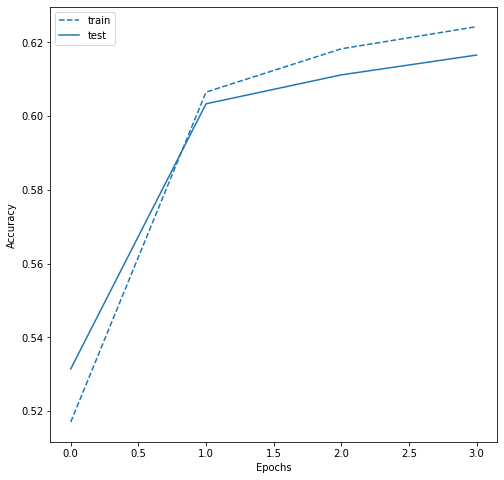

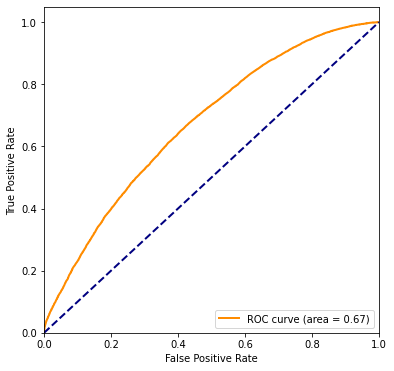

AUC score: 0.6704817845921653


In [27]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

plt.figure(figsize=(8, 8))

t = plt.plot(accuracy_train, '--', label='train')
plt.plot(accuracy_test, label='test', color=t[0].get_color())

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.savefig("../grafi/accuracy_moja.pdf", bbox_inches='tight')

y_pred = net.predict(x_test)

plotting.plot_roc(y_test, y_pred, "roc-moja.pdf")
plt.show()


auc = roc_auc_score(y_test, y_pred)
print("AUC score: {}".format(auc))




## Kaj zares je accuracy?

Accuracy sem preprosto implementiral vsi pravilni deljeni z vsemi meritvami, oziroma malce bolj formalno se glasi $A = \frac{TP + TN}{TOTAL}$. AUC (integral po ROC) je malo težje na roke prikazati, zato sem ta del prepustil Tensorflowu.

## Kako se moja NN primerja z Tensorflow

In [28]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense
from tensorflow import keras
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# some plotting routines
import plotting

# data processing
import data_higgs as dh

# import the working methods
print("TensorFlow version ", tf.__version__)

print("TF Keras version ", tf.keras.__version__)


TensorFlow version  2.7.0
TF Keras version  2.7.0


In [29]:
#--------- globals
BATCH_SIZE = 100


In [30]:
# Training progress and eval results are shown as logging.INFO; so enables it.

# needs to be done once if the h5 files need to be recreated...
# dh.download_and_make_data()

# nepoch = 2

hdata = dh.load_data()
data_fnames = hdata['feature_names'].to_numpy()[1:]  # drop labels
n_dims = data_fnames.shape[0]
print("Entries read {} with feature names {}".format(n_dims, data_fnames))

# training sample, should split a fraction for testing
x_trn, y_trn = split_xy(hdata['train'])
x_train, x_test, y_train, y_test = train_test_split(
    x_trn, y_trn, test_size=0.1)  # 10% split
x_val, y_val = split_xy(hdata['valid'])  # independent cross-valid sample

print("Shapes train:{} and test:{}".format(x_train.shape, x_test.shape))

# plot distributions
# plotting.plot_sig_bkg_from_np_arrays(
#     x_train.to_numpy(), y_train.to_numpy(), data_fnames, logy=False)

# ready the data for TF
ds_train = tf.data.Dataset.from_tensor_slices(
    (x_train.to_numpy(), y_train.to_numpy()))
ds_train = ds_train.repeat()
ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)

ds_test = tf.data.Dataset.from_tensor_slices(
    (x_test.to_numpy(), y_test.to_numpy()))
ds_test = ds_test.repeat()
ds_test = ds_test.batch(BATCH_SIZE, drop_remainder=True)

train_steps = int(x_train.shape[0]/BATCH_SIZE)
test_steps = int(x_test.shape[0]/BATCH_SIZE)
print("Steps train:{} and test:{}".format(train_steps, test_steps))

# build a model - a DNN in TF 2.0
dnn = Sequential()
dnn.add(Dense(50, input_dim=n_dims, activation='relu'))
dnn.add(Dense(50, input_dim=n_dims, activation='relu'))
dnn.add(Dense(1, activation='sigmoid'))  # output layer/value
plot_model(dnn, to_file='dnn_model.png', show_shapes=True)

dnn.compile(optimizer=tf.keras.optimizers.RMSprop(),
            loss='mean_squared_error',
            metrics=['accuracy', 'AUC', 'mean_squared_error'])

dnn.summary()

# optional early stopping
eval_metric = 'AUC'
earlystop_callback = EarlyStopping(
    mode='max',
    monitor='val_' + eval_metric,
    patience=5,
    min_delta=0.00001,
    verbose=1
)

# run the training
dnn_model_history = dnn.fit(ds_train,
                            epochs=nepoch,
                            steps_per_epoch=train_steps,
                            # callbacks=[earlystop_callback],
                            validation_data=ds_test,
                            validation_steps=test_steps
                            )

Loading /Users/greg/Documents/Šola/Faks/3 letnik/mpr/12 - ml/src/data/higgs-parsed/higgs-parsed.h5...
Loaded.
Entries read 18 with feature names ['lepton-pT' 'lepton-eta' 'missing-energy' 'jet_1-pt' 'jet_1-eta'
 'jet_2-pt' 'jet_2-eta' 'jet_3-pt' 'jet_3-eta' 'jet_4-pt' 'jet_4-eta'
 'm_jj' 'm_jjj' 'm_lv' 'm_jlv' 'm_bb' 'm_wbb' 'm_wwbb']
Shapes train:(360000, 18) and test:(40000, 18)
Steps train:3600 and test:400
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 50)                950       
                                                                 
 dense_7 (Dense)             (None, 50)                2550      
                                                               

2022-01-29 17:01:53.461585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


3594/3600 [============================>.] - ETA: 0s - loss: 0.2272 - accuracy: 0.6191 - auc: 0.6646 - mean_squared_error: 0.2272

2022-01-29 17:02:20.914199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


3600/3600 [==============================] - 30s 8ms/step - loss: 0.2272 - accuracy: 0.6191 - auc: 0.6646 - mean_squared_error: 0.2272 - val_loss: 0.2198 - val_accuracy: 0.6435 - val_auc: 0.6976 - val_mean_squared_error: 0.2198
Epoch 2/4
3600/3600 [==============================] - 29s 8ms/step - loss: 0.2159 - accuracy: 0.6530 - auc: 0.7094 - mean_squared_error: 0.2159 - val_loss: 0.2113 - val_accuracy: 0.6717 - val_auc: 0.7317 - val_mean_squared_error: 0.2113
Epoch 3/4
3600/3600 [==============================] - 29s 8ms/step - loss: 0.2074 - accuracy: 0.6755 - auc: 0.7377 - mean_squared_error: 0.2074 - val_loss: 0.2047 - val_accuracy: 0.6855 - val_auc: 0.7488 - val_mean_squared_error: 0.2047
Epoch 4/4
3600/3600 [==============================] - 30s 8ms/step - loss: 0.2024 - accuracy: 0.6859 - auc: 0.7511 - mean_squared_error: 0.2024 - val_loss: 0.2001 - val_accuracy: 0.6931 - val_auc: 0.7594 - val_mean_squared_error: 0.2001


history values dict_keys(['loss', 'accuracy', 'auc', 'mean_squared_error', 'val_loss', 'val_accuracy', 'val_auc', 'val_mean_squared_error'])


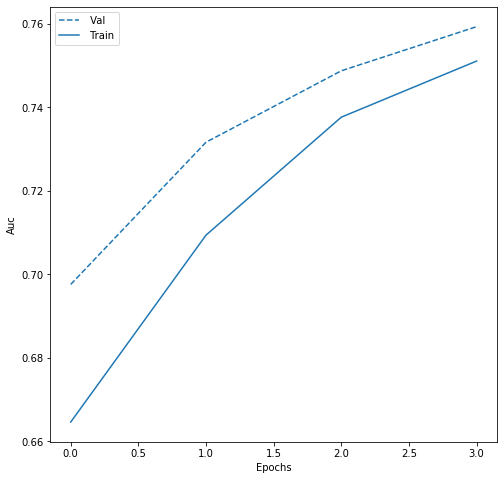

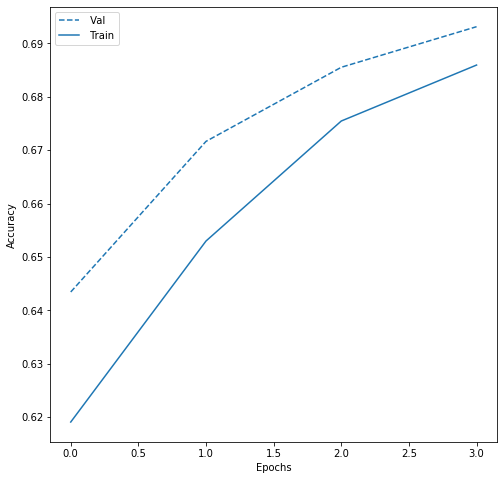

2022-01-29 17:03:50.474094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


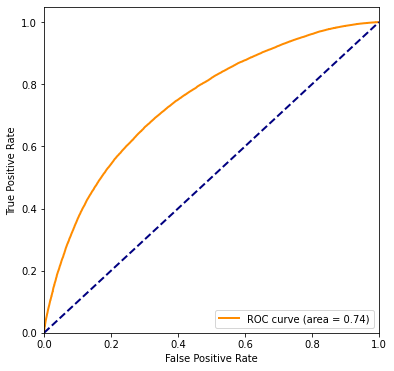

AUC score: 0.744054499612314


In [31]:
# plot training history
print("history values", dnn_model_history.history.keys())

dnn_model_history.history['val_auc']

for key in ["auc", "accuracy"]:
    plt.figure(figsize=(8, 8))
    val = plt.plot(dnn_model_history.epoch, dnn_model_history.history['val_' + key],
                   '--', label=' Val')
    plt.plot(dnn_model_history.epoch, dnn_model_history.history[key], color=val[0].get_color(),
             label=' Train')

    plt.xlabel('Epochs')
    # plt.title("Training History, {}".format(key))
    plt.ylabel(key.replace('_', ' ').title())
    plt.legend()

    plt.savefig("../grafi/tf_{}.pdf".format(key))
    plt.show()


y_score = dnn.predict(x_val.to_numpy())[:, 0]

plotting.plot_roc(y_val, y_score, "roc-tf.pdf")
plt.show()


auc = roc_auc_score(y_val, y_score)
print("AUC score: {}".format(auc))


## Najboljsa mozna

In [ ]:
def main(nepoch=10):
    # Training progress and eval results are shown as logging.INFO; so enables it.

    # needs to be done once if the h5 files need to be recreated...
    # dh.download_and_make_data()

    hdata = dh.load_data()
    data_fnames = hdata['feature_names'].to_numpy()[1:]  # drop labels
    n_dims = data_fnames.shape[0]
    print("Entries read {} with feature names {}".format(n_dims, data_fnames))

    # training sample, should split a fraction for testing
    x_trn, y_trn = split_xy(hdata['train'])
    x_train, x_test, y_train, y_test = train_test_split(
        x_trn, y_trn, test_size=0.1)  # 10% split
    x_val, y_val = split_xy(hdata['valid'])  # independent cross-valid sample

    print("Shapes train:{} and test:{}".format(x_train.shape, x_test.shape))

    # plot distributions
    # plotting.plot_sig_bkg_from_np_arrays(
    #     x_train.to_numpy(), y_train.to_numpy(), data_fnames, logy=False)

    # ready the data for TF
    ds_train = tf.data.Dataset.from_tensor_slices(
        (x_train.to_numpy(), y_train.to_numpy()))
    ds_train = ds_train.repeat()
    ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)

    ds_test = tf.data.Dataset.from_tensor_slices(
        (x_test.to_numpy(), y_test.to_numpy()))
    ds_test = ds_test.repeat()
    ds_test = ds_test.batch(BATCH_SIZE, drop_remainder=True)

    train_steps = int(x_train.shape[0]/BATCH_SIZE)
    test_steps = int(x_test.shape[0]/BATCH_SIZE)
    print("Steps train:{} and test:{}".format(train_steps, test_steps))

    # build a model - a DNN in TF 2.0
    dnn = Sequential()
    dnn.add(Dense(50, input_dim=n_dims, activation='relu'))
    dnn.add(Dense(50, input_dim=n_dims, activation='relu'))
    dnn.add(Dense(1, activation='sigmoid'))  # output layer/value
    plot_model(dnn, to_file='dnn_model.png', show_shapes=True)

    dnn.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='binary_crossentropy',
                metrics=['accuracy', 'AUC', 'binary_crossentropy'])

    dnn.summary()

    # optional early stopping
    eval_metric = 'AUC'
    earlystop_callback = EarlyStopping(
        mode='max',
        monitor='val_' + eval_metric,
        patience=5,
        min_delta=0.00001,
        verbose=1
    )

    # run the training
    dnn_model_history = dnn.fit(ds_train,
                                epochs=nepoch,
                                steps_per_epoch=train_steps,
                                # callbacks=[earlystop_callback],
                                validation_data=ds_test,
                                validation_steps=test_steps
                                )

    # plot training history
    print("history values", dnn_model_history.history.keys())
    plotting.plot_history(
        [('DNN model', dnn_model_history), ], key='binary_crossentropy')
    plotting.plot_history([('DNN model', dnn_model_history), ], key='auc')
    plotting.plot_history([('DNN model', dnn_model_history), ], key='accuracy')

    # plot & print results like ROC and score distribution etc...
    y_score = dnn.predict(x_val.to_numpy())[:, 0]
    plotting.plot_roc(y_val, y_score)
    plotting.plot_score(y_val, y_score)
    print()
    auc = roc_auc_score(y_val, y_score)
    print("AUC score: {}".format(auc))
